`DSCI 100 003 Introduction to Data Science   Group 24   December 6, 2025`

## **Identifying Player Characterists with High Yield Hours in Multiplayer Gameplay on Minecraft Server**

###### CONTENTS
[Introduction](#introduction)  |  [Methods](#methods)  |  [Results](#results)  |  [Discussion](#discussion)  |  [References](#references)

In [74]:
###### importing necessary libraries with supressed message for readability
library(dplyr      ,include = FALSE) 
library(tidyverse  ,include = FALSE)
library(GGally     ,include = FALSE)
library(tidymodels ,include = FALSE)
library(tidyclust  ,include = FALSE)
library(ISLR       ,include = FALSE)

#### **Introduction**  <a name="introduction"></a>
The Pacific Laboratory of Artificial Intelligence (PLAI) at UBC has set up a free Minecraft server with the goal to record 10,000 hours of multiplayer gameplay [1]. With this goal in mind, this project analyzes individual player data to understand whether PLAI can utilize targeted outreach to maximize average data contribution. This question is addressed with the `players` data; the `sessions` data is ignored due to it's lack of player specific characteristics.

<div style="display: inline-block; width: 100%;">
   <img src="./Images/Plaimage.png" alt="A screenshot of the PLAICRAFT Minecraft server that says the free server helps AI research">
   <p style ="text-align:center; font-style:italic;">  <b> Figure 1: </b>  Screenshot of the PLAICRAFT Minecraft Server  </p>
</div>

In [75]:
# loading players.csv data
  players <- read_csv("https://raw.githubusercontent.com/vicky-nak/DSCI-Final-Report-24/refs/heads/main/players.csv", show_col_types = FALSE)

###### **DATA EXPLORATION**
_Through analyzing the variables we aim to highlight points of interest in the data within the scope interest._

<div style="display: inline-block;">
    
| Variable         | Type      | Description w/ examples                             |  Statistics / Observations                                                                 |
| --------------:  | --------: | --------------------------------------------------: | :----------------------------------------------------------------------------------------- |
| **experience**   | character | Self-reported knowledge of minecraft                | `63 Amateurs` `35 Beginners` `14 Pros` `48 Veterans` `36 Regulars`                         |
| **subscribe**    | logical   | True if player subscribed to newsletter             | `144 Subscribed` `52 Not subcribed`                                                        |
| **hashedEmail**  | character | Encrypted player email                              |                                                                                            |
| **played_hours** | numeric   | Hours of logged gaming time to one decimal place    | `5.85 Mean` `85 Non Players`                                                               |
| **name**         | character | Player name                                         | `196 Players`                                                                              |
| **gender**       | character | Player gender                                       | `124 Males` `37 Females` `15 Non-binary` `6 Two-Spirited` `1 Other` `11 Prefer not to say` |
| **Age**          | numeric   | Player age                                          | `21.4 Mean` `19 Median`                                                                    |

</div>

###### **RESEARCH QUESTION**
##### Given whether a player logs game hours, is a player's experience, subscription satus, gender, or age indicative of their played hours?

###### VARIABLE ANALYSIS
We identify `played_hours` as the most appropriate measure of data contribution. However within this variable, 43.4% of users record 0 played hours. This suggests our study can identify targets for data contribution by:
1. Assesing similarities between non-players to identity users to avoid
2. Identifying which player characteristics are predictors of played_hours to identify users to target

#### **Methods** <a name="methods"></a>

###### **EXPLORATORY DATA ANALYSIS AND VISUALIZATION**

###### DATA QUANTIFICATION (Dummy Variables)
To easily work with the data, the appropriate variables were chosen and then quanitfied. Firstly hashedEmail and name were removed from the data and then experience, subscribe, and gender were made numeric. 

In [77]:
players_num <- players |>
    filter(!is.na(Age), na.rm = TRUE) |> mutate(age = Age) |>
    mutate(experience = case_when(experience == "Beginner" ~ 1,  # Given the order (with reference to PLAI) 
                                  experience == "Amateur"  ~ 2,  # ordinal encoding was used for a 1-5 scale
                                  experience == "Regular"  ~ 3, 
                                  experience == "Pro"      ~ 4,
                                  experience == "Veteran"  ~ 5)) |>
    mutate(subscription_status = as.numeric(subscribe)) |>       # Using binary where True = 1, False = 0
    mutate(gender = case_when(gender == "Male"   ~ 1,   # While not ordinal, for better outcomes, the data was combined into 3 categories given the 
                              gender == "Female" ~ 2,   # lack of data on genders other than Male and Female
                              gender == "Other"  ~ 3, gender == "Two-Spirited" ~ 3, gender == "Agender" ~ 3, gender == "Non-binary" ~ 3, gender == "Prefer not to say" ~ 3)) |>
    filter(!is.na(gender), na.rm = TRUE) |>
    select(played_hours, experience, subscription_status, age, gender)

###### GGPAIR PLOT 

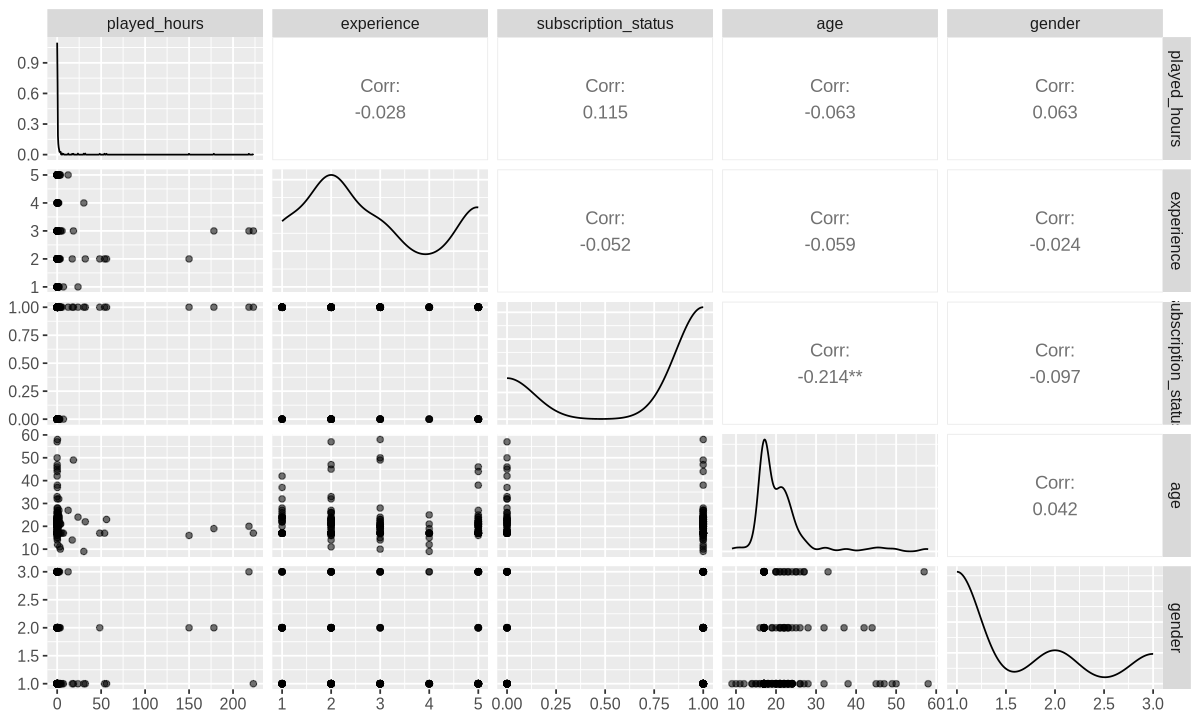

In [79]:
options(repr.plot.height = 6, repr.plot.width = 10)
# Using ggpairs, we can observe the relationships between variables to discern which ones are best to focus on.
players_num |> ggpairs(aes(alpha = 0.05)) + theme(text = element_text(size = 12)) 

###### GGpair plot observations
Despite low correlation between all variables, a closer look at the plots reveals some variables of interest regarding played_hours
1. Unsubscribed players are seemingly never likely to log a significant amount of hours played
2. Experience levels 1 and 5 (Beginners and Veterans) are also unlikely to log hours played, and 2 and 4 (Amatuers and Regulars) are msot likely to log significant hours
3. Ages 30 to 60 are unlikely to log many played hours with most likely being around age 20

Based on these observations our analysis will will narrow our research question to focus on the predictors: `experience`, `subscription_status`, and `age`.

###### **CHOOSING AN ANALYTICAL APPROACH**
It is evident played_hours does not share a linear relationship with the independent variables, therefore a regression of the data may not do it justice. Additionally, with over 40% of players not logging any played hours, a research team may be more interested in identifying players that contribute a significant amount of data, rather than predicting the amount of data (played_hours) they will log. Based on this, with a categorical dependant variable, we can conduct a classification on our data. 

###### TRANSFORMING PLAYED_HOURS INTO A CATEGORICAL VARIABLE
Using a histogram we can map out the various "sections" of played hours to observe some patterns and identify common hours played

In [80]:
# as logging zero played hours is significant categorically, we conduct the distribution on players that logged more than zero hours
all_players <- players_num |> filter(played_hours != 0) 

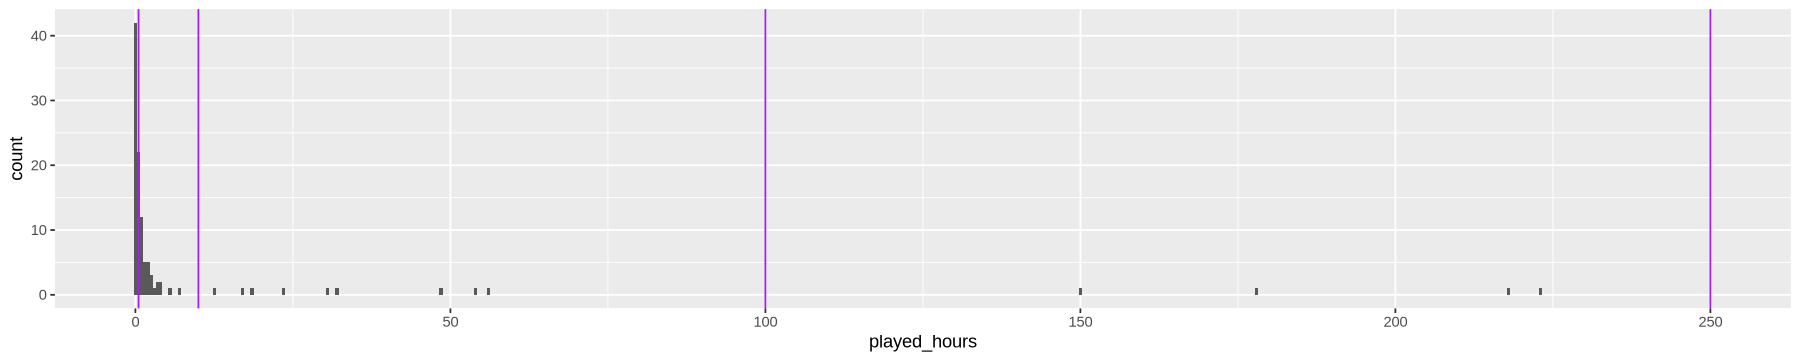

In [81]:
options(repr.plot.height = 3, repr.plot.width = 15)
# vertical lines bound off the data into bins
ggplot(all_players, aes(x = played_hours)) + geom_histogram(binwidth = 0.5) + geom_vline(xintercept = c(0.5, 10.0, 100.0, 250.0), color = "purple")

In [88]:
# Converting played_hours into a categorical variable as defined by the bounds above
players_data <- players_num |> 
    mutate(amount_played =  case_when(played_hours == 0.0 ~ "Non", played_hours > 100  ~ "Extreme",  played_hours > 10.0 ~ "High", 
                                      played_hours > 0.50 ~ "Med", played_hours > 0.00 ~ "Low")) |>
    select(amount_played, subscription_status, experience, age)

###### **SPLITING DATA**
Spliting the data into a testing and training set

In [89]:
set.seed(1000) # This analysis utilizes seed no. 1000
players_split    <- initial_split(players_data, prop = 0.75, strata = amount_played)
players_training <- training(players_split)
players_testing  <- testing(players_split)

#### **Results** <a name="results"></a>

In [ ]:
set.seed(1000)
kmeans_recipe <- recipe(~ ., data=non_players) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

kmeans_spec <- k_means(num_clusters = 3) |>
    set_engine("stats")

kmeans_fit <- workflow() |>
    add_recipe(kmeans_recipe) |>
    add_model(kmeans_spec) |>
    fit(data = non_players)

clustered_data <- kmeans_fit |>
                  augment(non_players)

cluster_plot <- ggplot(clustered_data,
  aes(x = subscribe,
      y = experience,
      color = .pred_cluster),
  size = 2) +
  geom_point() +
  labs(x = "Flipper Length",
       y = "Bill Length",
       color = "Cluster") +
  scale_color_manual(values = c("steelblue",
                                "darkorange",
                                "goldenrod1")) +
  theme(text = element_text(size = 12))

clustered_data_1 <- clustered_data |>
    ggplot(aes(y = played_hours, x=.pred_cluster, color = gender)) +
  geom_point(alpha = 0.4) +
  theme(text = element_text(size = 12))

clustered_data_1

In [ ]:
# removing variables not to be considered for model selection
model_selection_players <- players |> select(-hashedEmail, -name)

null_model <- lm(played_hours ~ 1, data = model_selection_players)
final_model <- lm(played_hours ~ experience + subscribe + gender + Age, data = model_selection_players)
forward_model <- step(null_model, scope = list(lower = null_model, upper = final_model), direction = "forward")

_describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.
your report should include code which:
loads data 
wrangles and cleans the data to the format necessary for the planned analysis
performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
performs the data analysis
creates a visualization of the analysis 
note: all figures should have a figure number and a legend_

###### CLUSTERING NON PLAYERS
---

###### WRANGLING
---

###### RESEARCH QUESTION

#### Discussion <a name="discussion"></a>
_summarize what you found
discuss whether this is what you expected to find
discuss what impact could such findings have
discuss what future questions could this lead to_

#### References <a name="references"></a>
[1]  Smith, A. (2025, January 21). Plaicraft.ai launch. Pacific Laboratory for Artificial Intelligence. https://plai.cs.ubc.ca/2023/09/27/plaicraft/  
[2]  James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. 2013. An Introduction to Statistical Learning. 1st ed. Springer. https://www.statlearning.com/. 